In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline


In [146]:
df = pd.read_csv('./database.sqlite')

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


- CASEID - case number
- DOF1 - direction of force (highest)
- GAD1 - deformation location (highest)
- PSU - primary sampling unit number
- YEAR - calender year of crash
- STRATIF - case stratum
- BODYTYPE - vehicle body type
- DVEST - estimated highest delta V
- DVBASIS - basis for total deltav V (highest)
- DVTOTAL - total delta V
- MAKE - vehicle make
- MODELYR - vehicle model year
- AGE - age of occupant
- BAGAVAIL - air bag system availability
- BAGDEPLY - air bag system deployed
- BAGFAIL - air bag system failure
- CASENO - case sequence number
- CHTYPE - type of child safety seat
- DEATH - time of death
- HEIGHT - height of occupent
- HOPSTAY - hospital stay
- INJSEV - injury severity (police rating)
- MANAVAIL -
- MANFAIL - 
- MANUSE - manual belt system use 
- OCCNO - occupant number
- ROLE - occupant's role
- SEATPOS - occupant's seat position
- SEX - occupant's sex
- TREATMENT - treatment - mortality
- WEIGHT - occupant's weight

In [147]:
fatal = df.copy()

In [148]:
fatal.columns

Index(['Unnamed: 0', 'CASEID', 'DOF1', 'GAD1', 'PSU', 'YEAR', 'STRATIF',
       'BODYTYPE', 'DVEST', 'DVBASIS', 'DVTOTAL', 'MAKE', 'MODELYR', 'AGE',
       'BAGAVAIL', 'BAGDEPLY', 'BAGFAIL', 'CASENO', 'CHTYPE', 'DEATH',
       'HEIGHT', 'HOSPSTAY', 'INJSEV', 'MANAVAIL', 'MANFAIL', 'MANUSE',
       'OCCNO', 'ROLE', 'SEATPOS', 'SEX', 'TREATMNT', 'WEIGHT'],
      dtype='object')

In [149]:
# changing all columns to lower case
columns = fatal.columns
columns_lower = []
for col in columns:
    columns_lower.append(col.lower())
fatal.columns = columns_lower

In [150]:
## removed unnamed: 0 column since it matched the index
fatal.drop(labels='unnamed: 0',axis=1,inplace=True)

In [151]:
# dictionay of categorie ID's (named how they will appear when get dummies is applied)
dvest = {'dvest_0':'reconstructed_dv','dvest_1':'dv<10kmph','dvest_2':'10 >= dv < 25kmph','dvest_3':'25 >= dv < 40kmph',
         'divest_4':'40 >= dv <55kmph','divest_5':'dv >= 55kmph','divest_6':'minor damage','divest_7':'moderat damage',
         'divest_8':'severe damage'}

dvbasis = {'dvbasis_0':'not_ispctd','dvbasis_1':'S_dmg_only','dvbasis_2':'S_dmg_&_trjctry','dvbasis_3':'S_missing_vhcl', 
           'dvbasis_4':'S_dmg_cdc_only', 'dvbasis_5':'one_vhcle_byond_S_scope','dvbasis_6':'rollover',
           'dvbasis_7':'non_hrzntl_forces','dvbasis_8':'sideswipe_dmg','dvbasis_9':'severe_override',
          'dvbasis_10':'ylding_objct','dvbasis_11':'overlapping_dmg','dvbasis_12':'insuf_data',
           'dvbasis_98':'other','dvbasis_99':'unknown'}

gad1 = {'gad1_F':'front','gad1_L':'left','gad_R':'right','gad1_B':'back','gad1_uk':'unkown','gad1_T':'top',
        'gad1_U':'undercarriage'}


bagavail = {'bagavail_1':'no','bagavail_2':'yes','bagavail_3':'unknown'}
# stratif = {'stratif_k':'fatality','stratif_F':'injry_no_tow_hsptl',
#           'stratif_E':'injry_tow','stratif_C':'two_tow_no_hsptl','stratif_D':}
# air bad deployed 
bagdeply = {'bagdeply_0':'no_bag', 'bagdeply_1':'impct_deply','bagdeply_3':'deply_ukdetls',
            'bagdeply_5':'uk_deply','bagdeply_7':'no_deply'}

# air bag failure
bagfail = {'bagfail_0':'no_bag','bagfail_1':'no','bagfail_2':'yes'}

# child seat type
chtype = {'chtype chtype _0':'none','chtype_1':'conv_seat','chtype_2':'frwd_face','chtype_3':'infnt_seat',
          'chtype_4':'boost_seat','chtype_7':'vest','chtype_8':'harness'}

# Injury severity
injsev = {'injsev_0':'no_inj','injsev_1':'pssbl_inj','injsev_2':'n_incptng_inj','injsev_3':'incptng_inj',
          'injsev_4':'killed','injsev_5':'inj_sev_uk','injsev_6':'die_b4_crsh'}

# Drop mannavail since it's same data as manuse
# Manual seatbelt used
manuse = {'manuse_0':'none','manuse_1':'inoperative','manuse_2':'shldr_b','manuse_3':'lap_b',
          'manuse_4':'laphshldr_b','manuse_5':'b_avail_uk','manuse_8':'othr_b_use',
          'manuse_12':'shldr_chld_seat','manuse_13':'lap_chld_seat','manuse_14':'lapshldr_chld_seat',
          'manuse_15':'b_chld_seat_uk','manuse_18':'othrb_chld_seat'}

# Manual seatbelt fail
manfail = {'manfail_0':'nouse','manfail_1':'no_mlfctn',
           'manfail_2':'torn_wbbng','manfail_3':'bckl',
           'manfail_4':'uppr_anchr','manfail_5':'othr_anchr',
           'manavail_6':'retrctr','manavail_7':'combo',
           'manfail_8':'other'}

role = {'role_1':'driver','role_2':'passenger'}



In [152]:
# replace 9 with uk for (unknown per the NASS documents)
fatal['gad1'] = fatal['gad1'].copy().replace('9','uk')

In [153]:
# replace 0 with 1 since they are the same thing according to the NASS documents
fatal['bagavail'] = fatal['bagavail'].copy().replace(0,1,axis=0)

/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [154]:
# removing letter at the end and going to drop caseno and PSU since 
# they "are identical variables across all NASS records"
fatal['caseid'] = fatal['caseid'].apply(lambda x: x[:-1].strip())

In [155]:
# according NASS these columns are same info as caseid
fatal.drop(['psu','caseno'],axis=1,inplace=True)

In [156]:
# after further review of the data dropping 'caseid' colunm since there is no significance in the scope
fatal.drop('caseid',axis=1,inplace=True)

In [157]:
# remove manavail since manuse gives the same information
fatal.drop('manavail', axis=1, inplace=True)

In [158]:
# remove bagavail since bagdeply has the same information
fatal.drop('bagavail', axis=1, inplace=True)

In [159]:
#  Remove occno since it's same informaton covered by seatpos
fatal.drop('occno', axis=1, inplace=True)

In [160]:
# Dictionary of each column's unique values key = counts, value = feature name
unique_dict = {}
for col in fatal.columns:
    unique_dict[col] =  fatal[col].nunique()

# Features <30 counts
categoricals = []
for key in unique_dict.keys():
    if unique_dict[key] < 30:
        categoricals.append(key)

In [161]:
for col in categoricals:
    print(col)
    print(fatal[col].value_counts())

gad1
F     1372618
L      411350
B      330703
R      319169
uk     100183
T       65536
U        3328
Name: gad1, dtype: int64
year
2004    544672
2006    500428
2005    494713
2007    243975
2008    195223
2009    181650
2010    157642
2011    150124
2012    104230
2014    103450
2013     22257
2015     18063
Name: year, dtype: int64
stratif
K    529817
F    442408
E    385249
C    236676
D    235326
G    230456
B    226083
H    214204
J    156951
A     59252
Name: stratif, dtype: int64
dvest
0.0    1674684
7.0     306520
6.0     131007
8.0      84874
2.0      12325
3.0       5534
1.0       3007
5.0       2872
4.0       1199
Name: dvest, dtype: int64
dvbasis
1.0     1035657
3.0      587972
11.0     301492
0.0      295200
4.0      109304
7.0       66250
5.0       53107
10.0      49190
98.0      40293
6.0       37035
9.0       32346
8.0       17075
2.0        1522
Name: dvbasis, dtype: int64
bagdeply
1.0    801298
7.0    779497
0.0    673300
5.0     32038
3.0     26686
Name: bagdeply, 

In [162]:
# Grouping:
# (0, 1, 2,) --> non-sevear
# (3) --> sevear
# (4, 6) --> death 
# 5 is injured, but unknown severity --> need to impute
fatal['injsev'].value_counts()

0.0    941331
3.0    588483
1.0    582178
2.0    421564
4.0     96423
5.0     36568
6.0        56
Name: injsev, dtype: int64

In [ ]:
# fatal['injsev'].replace(to_replace=[0.0, 1.0, 2.0], value=['unsevere','unsevere','unsevere'])

In [ ]:
# fatal['injsev'].replace

In [163]:
fatal.isnull().sum()

dof1         299352
gad1         113540
year              0
stratif           5
bodytype       2519
dvest        494405
dvbasis       89984
dvtotal     1091276
make          10659
modelyr       13077
age           56349
bagdeply     403608
bagfail      576251
chtype       284986
death        327097
height       689620
hospstay     394158
injsev        49824
manfail      680669
manuse       495745
role            200
seatpos      190062
sex           32035
treatmnt     331950
weight       654910
dtype: int64

In [164]:
# dvtotal has 1,091,276 null values.  From the analysis below, that accounts 35 to 50 % of each year's data
# Dropping these Na data points
dvtotal_na = pd.DataFrame(fatal[ fatal['dvtotal']\
                                .isnull() ]['year']\
                                .value_counts()).sort_index(ascending=True)

total = pd.DataFrame(fatal['year'].value_counts()).sort_index(ascending=True)

na_percent = pd.concat([dvtotal_na,total], axis=1)
na_percent.columns = ['NAs','Total']

na_percent['Percentage'] = (na_percent['NAs'] / na_percent['Total']).round(3)

print(na_percent.sort_index(ascending=True))
print()
print('There is an average of {}'.format((na_percent['Percentage'].mean().round(3))*100) + '% NA values')

         NAs   Total  Percentage
2004  190316  544672       0.349
2005  184505  494713       0.373
2006  197452  500428       0.395
2007  104293  243975       0.427
2008   84793  195223       0.434
2009   80094  181650       0.441
2010   69222  157642       0.439
2011   65682  150124       0.438
2012   53511  104230       0.513
2013    9208   22257       0.414
2014   45168  103450       0.437
2015    7032   18063       0.389

There is an average of 42.1% NA values


## Try Dropping NA

In [165]:
fatal_nona = fatal.copy()

# dropping all Na values ~ 42% of the data
fatal_nona.dropna(axis=0,inplace=True)

In [166]:
# Turn floats into integers
floats = fatal_nona.dtypes[ fatal_nona.dtypes == 'float64' ].index.tolist()

fatal_nona[floats] = fatal_nona[floats].astype('int')

### Imputing 'injsev' category 5 (Injury-Unknown Severity)

In [167]:
impute_five = fatal_nona.copy()

In [168]:
# join get_dummies data frame with the original data
impute_five = pd.concat([impute_five, pd.get_dummies(impute_five[['gad1','stratif']])],axis=1)

In [173]:
X_train = impute_five[ impute_five['injsev'] != 5 ].drop(['injsev','gad1','stratif'], axis=1)
y_train = impute_five[ impute_five['injsev'] != 5 ]['injsev']

X_test = impute_five[ impute_five['injsev'] == 5 ].drop(['injsev','gad1','stratif'], axis=1)
y_test = impute_five[ impute_five['injsev'] == 5 ]['injsev']

In [175]:
# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [181]:
dt_impute = DecisionTreeClassifier()
dt_impute.fit(X_train_ss, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [182]:
s = cross_val_score(dt_impute, X_train_ss, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.529 ± 0.037


In [216]:
# although the accuracy is not very good for the estimations, 
#(0, 1, 2) were going to be classified as 'unsevere'
# (3) will be 'severe' and of all the predicted values there was only 6% classified as 3

print(set(dt_impute.predict(X_test_ss).tolist()))
print('0 sum = ',(dt_impute.predict(X_test_ss)==0).sum())
print('1 sum = ',(dt_impute.predict(X_test_ss)==1).sum())
print('2 sum = ',(dt_impute.predict(X_test_ss)==2).sum())
print('3 sum = ',(dt_impute.predict(X_test_ss)==3).sum())
print()
print('Percent of 3 = ',(dt_impute.predict(X_test_ss)==3).sum()/dt_impute.predict(X_test_ss).sum())

{0, 1, 2, 3}
0 sum =  1629
1 sum =  4187
2 sum =  3591
3 sum =  764

Percent of 3 =  0.05592562769928995


In [233]:
fatal_nona[ fatal_nona['injsev']==5 ]['injsev']

6714       5
6721       5
6728       5
6735       5
6742       5
6749       5
6756       5
6763       5
6770       5
6777       5
6784       5
6791       5
6798       5
6805       5
6812       5
6819       5
6826       5
6833       5
6840       5
6847       5
6854       5
6861       5
6868       5
6875       5
6882       5
6889       5
6896       5
6903       5
6910       5
6917       5
          ..
2590713    5
2590718    5
2590723    5
2590728    5
2590733    5
2590738    5
2590743    5
2590748    5
2590753    5
2590758    5
2590763    5
2590768    5
2590908    5
2590909    5
2590911    5
2590912    5
2590914    5
2590915    5
2590917    5
2590918    5
2590920    5
2590922    5
2594337    5
2594339    5
2594341    5
2594343    5
2596097    5
2596101    5
2596105    5
2596109    5
Name: injsev, Length: 10171, dtype: int64

In [243]:
# cat_five_imputed = pd.Series(dt_impute.predict(X_test_ss).tolist())
# fatal_nona.replace(to_replace = fatal_nona[ fatal_nona['injsev']==5 ]['injsev'],
#                    value = cat_five_imputed,
#                    axis=0,
#                   inplace=True)


/Users/guillermogonzalez/miniconda3/envs/ga/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [244]:
fatal_nona['injsev'].value_counts()

0    370120
3    241780
1    240018
2    168000
4     17935
5     10171
6         8
Name: injsev, dtype: int64

In [259]:
print(len(fatal_nona[ fatal_nona['injsev']==5]['injsev']))
print(len(cat_five_imputed))

10171
10171


In [271]:
pd.concat([fatal_nona[ fatal_nona['injsev']==5]['injsev'], cat_five_imputed],axis=1,join='outer',ignore_index=True)

,0,1
0,NaN,1.0
1,NaN,1.0
2,NaN,1.0
3,NaN,1.0
4,NaN,1.0
5,NaN,1.0
6,NaN,1.0
7,NaN,1.0
8,NaN,1.0
9,NaN,1.0


In [86]:
# join get_dummies data frame with the original data
fatal_nona = pd.concat([fatal_nona, pd.get_dummies(fatal_nona[['gad1','stratif']])],axis=1)

In [87]:
y = fatal_nona['injsev']
X = fatal_nona.copy().drop(['injsev','gad1','stratif','caseid'], axis=1)

In [88]:
# creating the test train split for multiclass modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    stratify=fatal_nona['injsev'])

In [89]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(838425, 38) (838425,) (209607, 38) (209607,)


In [91]:
# Standardizing the train and test data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [92]:
dt = DecisionTreeClassifier(min_samples_leaf=10)
s = cross_val_score(dt, X_train_ss, y_train, cv=5, n_jobs=2)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.964 ± 0.001


In [93]:
dt.fit(X_train_ss, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [94]:
confusion_matrix(y_test, dt.predict(X_test_ss))

array([[72794,   744,   348,    68,     0,    70,     0],
       [  982, 45882,   712,   303,     0,   125,     0],
       [  444,   782, 31975,   325,     0,    74,     0],
       [   79,   344,   339, 47574,    10,    10,     0],
       [    2,     2,     2,     5,  3576,     0,     0],
       [   82,   130,    87,    20,     0,  1715,     0],
       [    2,     0,     0,     0,     0,     0,     0]])

In [95]:
y_true = y_test.copy()
y_pred = dt.predict(X_test_ss)

In [96]:
confusion = pd.crosstab(y_true, y_pred)
confusion

col_0,0.0,1.0,2.0,3.0,4.0,5.0
injsev,,,,,,
0.0,72794,744,348,68,0,70
1.0,982,45882,712,303,0,125
2.0,444,782,31975,325,0,74
3.0,79,344,339,47574,10,10
4.0,2,2,2,5,3576,0
5.0,82,130,87,20,0,1715
6.0,2,0,0,0,0,0


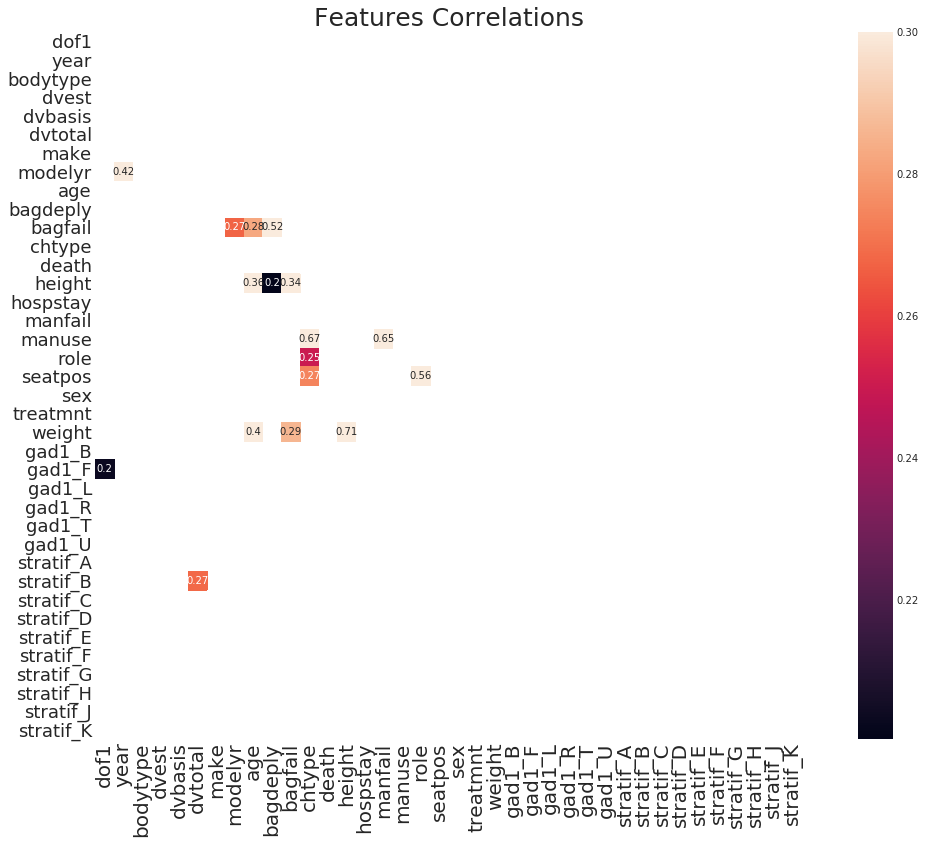

In [97]:
plt.figure(figsize=(20,13))
mask = np.zeros_like(X_train.corr()[X_train.corr()>0.20])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(X_train.corr()[X_train.corr()>0.20], mask=mask, vmax=.3, annot=True, square=True)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 18)
plt.title('Features Correlations', fontsize = 25)
plt.show()


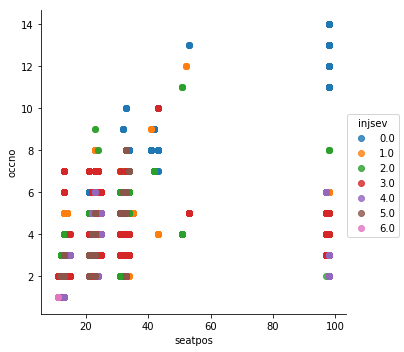

In [60]:
sns.lmplot(x='seatpos', y='occno', data=fatal_nona,
           fit_reg=False, 
           hue='injsev')

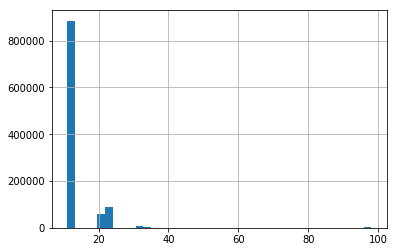

In [75]:
fatal_nona['seatpos'].hist(bins = 40)

In [73]:
fatal_nona['seatpos'].value_counts().index.sort_values()

Float64Index([11.0, 12.0, 13.0, 14.0, 15.0, 21.0, 22.0, 23.0, 24.0, 25.0, 31.0,
              32.0, 33.0, 34.0, 35.0, 41.0, 42.0, 43.0, 51.0, 52.0, 53.0, 97.0,
              98.0],
             dtype='float64')

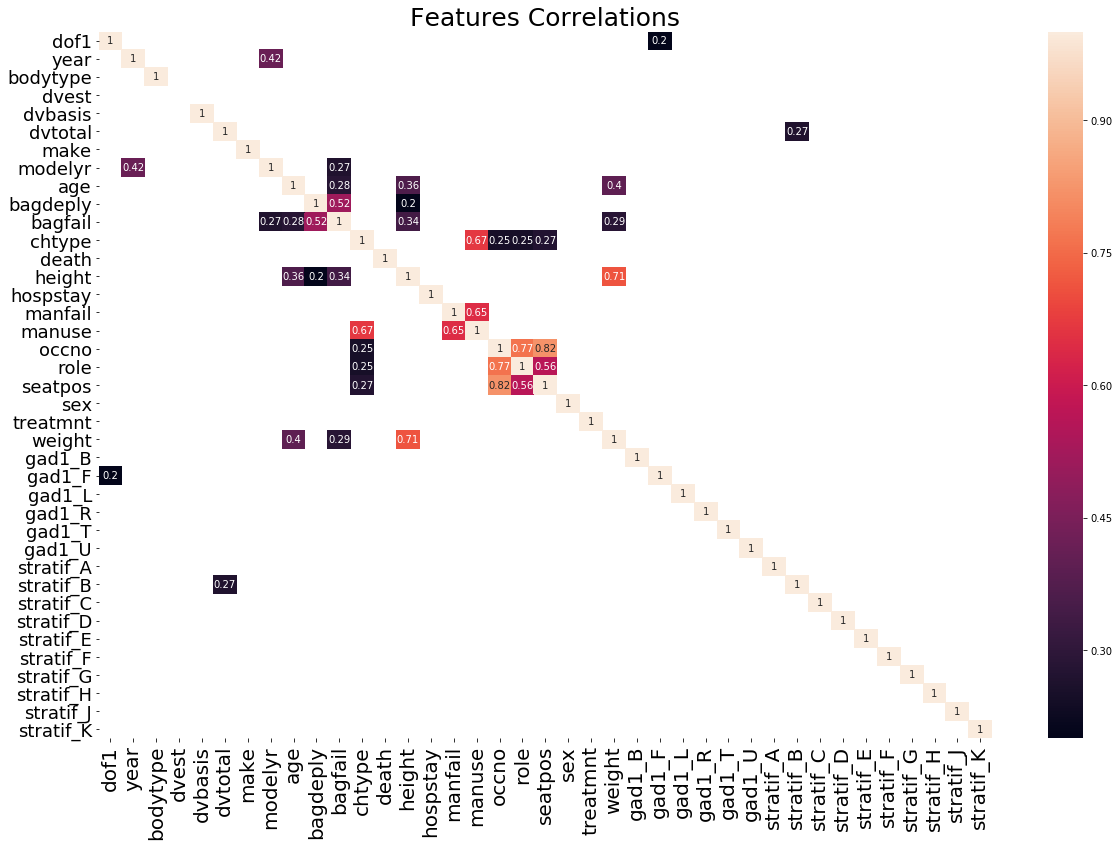

In [52]:
plt.figure(figsize=(20,13))
ax = sns.heatmap(X_train.corr()[X_train.corr()>0.20], annot=True, linecolor='g')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 18)
plt.title('Features Correlations', fontsize = 25)
plt.show()

# df = titanic.pivot_table(index='embark_town', columns='age_group', values='fare', aggfunc=np.median)
# sns.heatmap(df, annot=True, fmt=".1f")
# [X_train.corr()>0.30]

In [ ]:
feature_import = pd.concat([pd.Series(X_train.columns),
                            pd.Series(dt.feature_importances_.tolist())],
                           axis=1).sort_values(1,ascending=False)
feature_import.reset_index(level=0, drop=True, inplace=True)
feature_import.columns = ['feature','importance']

In [ ]:
plt.title('Feature Importances')
plt.barh( feature_import['importance'],color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance') 
plt.show()

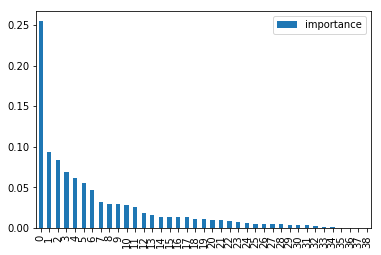

In [113]:
feature_import.plot(kind='bar')

In [ ]:
dt.predict(X_train)

In [ ]:

def build_tree_models(x, y, tree_depth_range=range(1,11), min_leaf):
    tree_model_ypreds = {}
    
    for i in tree_depth_range:
        model = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_leaf)
        model.fit(x[:, np.newaxis], y)
        tree_model_ypreds[i] = model.predict(x[:, np.newaxis])
        
    return tree_model_ypreds

In [ ]:
def mph(kmph):
    '''
    Function to convert kmph to mph.  
    Enter the speed in kmph and the function converts it to mph.
    - default set to 0.0001
    '''
    return round(0.621371*kmph)